In [2]:
import torch
import tinycudann as tcnn
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from process_data import process_radar_data

In [3]:
def get_config():

    config = {
        "encoding":{
        "otype": "HashGrid",
        "n_levels": 16,
        "n_features_per_level": 2,
        "log2_hashmap_size": 19,
        "base_resolution": 16,
        "per_level_scale": 1.5},

        "MLP":{
            "otype": "CutlassMLP",
            "activation": "Sine", 
            "output_activation": "None",
            "n_neurons": 128,
            "n_hidden_layers": 2},

        "model":{
            "input_dim":3, 
            "output_dim":2}
    }
    return config

In [4]:
def forward_model(f_est, H):
    ''' Forward model to compute the measurements
        field_estimate = -H.conj().T @ g 
        Therefore, g = -H @ field_estimate'''
    H_pseudo_inv = torch.linalg.pinv(H.conj().T)
    g = -H_pseudo_inv @ f_est
    return g

def safe_normalize(x, eps=1e-4):
    return x / torch.sqrt(torch.clamp(torch.sum(x * x, -1, keepdim=True), min=eps))

class InstantNGPFieldRepresentation(torch.nn.Module):
    def __init__(self, config=None):
        super().__init__()
        
        if config is None:
            config = get_config()

        encoding_config = config['encoding']
        network_config = config['MLP']

        self.encoding = tcnn.Encoding(
            n_input_dims=config['model']['input_dim'],
            encoding_config=encoding_config,
        )
        self.network = tcnn.Network(
            n_input_dims=self.encoding.n_output_dims,
            n_output_dims=config['model']['output_dim'],
            network_config=network_config,
        )
    
    def forward(self, coordinates):
        with torch.enable_grad():

            coordinates.requires_grad_(True)
            if not coordinates.is_cuda:
                coordinates = coordinates.to('cuda')

            x_encoded = self.encoding(coordinates)
            out = self.network(x_encoded).float()

            normals_out = - torch.autograd.grad(torch.sum(out.abs()),
                                                coordinates, create_graph=True)[0]
            normals_out = safe_normalize(normals_out).float()
            normals_out[torch.isnan(normals_out)] = 0
            
        return torch.complex(real=out[:, 0], imag=out[:, 1]).to('cuda'), normals_out

In [5]:
model = InstantNGPFieldRepresentation().cuda()
checkpoint = torch.load('/home/omkar/Desktop/All_Desktop_files/Projetcs/Neural_Radar_fields/synthetic_double_rec_v2/model_2_final.pth')
model.load_state_dict(checkpoint)
model.eval()


/tmp/ipykernel_2129103/410480087.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/omkar/Desktop/All_Desktop_files/Projetcs/Neural_Radar_fie

InstantNGPFieldRepresentation(
  (encoding): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float16, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 19, 'n_features_per_level': 2, 'n_levels': 16, 'otype': 'Grid', 'per_level_scale': 1.5, 'type': 'Hash'})
  (network): Network(n_input_dims=32, n_output_dims=2, seed=1337, dtype=torch.float16, hyperparams={'encoding': {'offset': 0.0, 'otype': 'Identity', 'scale': 1.0}, 'network': {'activation': 'Sine', 'n_hidden_layers': 2, 'n_neurons': 128, 'otype': 'CutlassMLP', 'output_activation': 'None'}, 'otype': 'NetworkWithInputEncoding'})
)

In [8]:
def plot_3D_results(X, Y, Z, f_est_3D, threshold_factor=0.7):
    """Plot 3D visualization of the results"""
    from skimage import measure
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection

    f_est_cube = np.abs(f_est_3D) ** 2

    isovalue = f_est_cube.max() * threshold_factor
    spacing = (X[1] - X[0]) * 1000, (Y[1] - Y[0]) * 1000, (Z[1] - Z[0]) * 1000
    verts, faces, normals, values = measure.marching_cubes(f_est_cube, level=isovalue, spacing=spacing)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.7)
    mesh.set_facecolor('red')
    ax.add_collection3d(mesh)

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')

    ax.set_xlim(verts[:, 0].min(), verts[:, 0].max())
    ax.set_ylim(verts[:, 1].min(), verts[:, 1].max())
    ax.set_zlim(verts[:, 2].min(), verts[:, 2].max())

    plt.title('Simulated data')
    plt.tight_layout()
    plt.show()

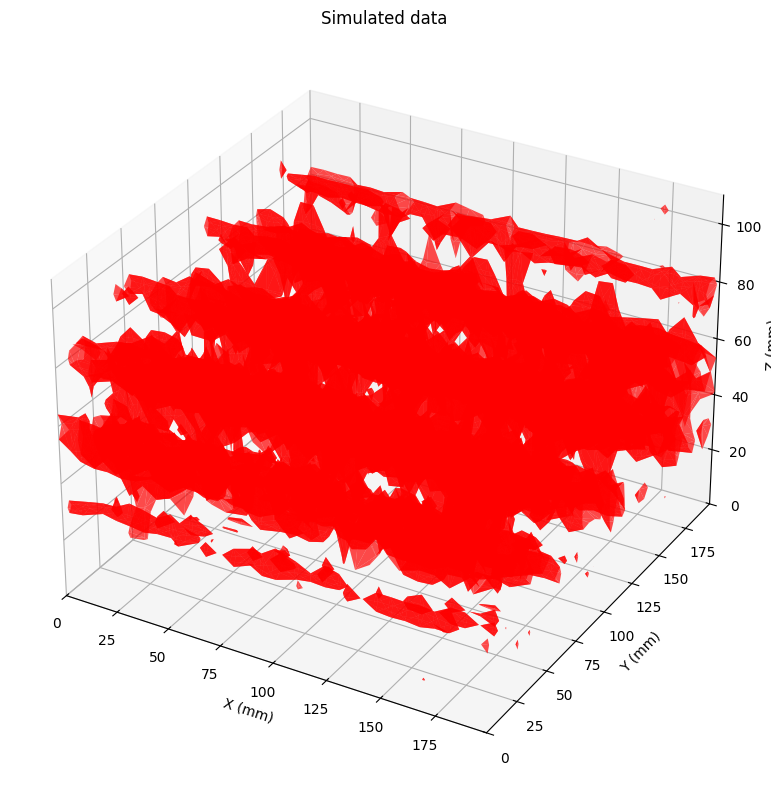

In [9]:
Z = np.linspace(90e-3, 200e-3, 12)
Y = np.linspace(-99e-3, 99e-3, 41)
X = np.linspace(-99e-3, 99e-3, 31)
coords = np.stack(np.meshgrid(X, Y, Z), -1).reshape(-1, 3)

coords_tensor = torch.tensor(coords, dtype=torch.float32).cuda()

f_est, normals = model(coords_tensor)

f_est = f_est.cpu().detach().numpy()
f_est = f_est.reshape(X.shape[0], Y.shape[0], Z.shape[0], order='F')
plot_3D_results(X, Y, Z, f_est)
